In [71]:
import sys, os
sys.path.append(os.path.dirname(os.getcwd())) 

from utils.generate_model import init_state, load_trained_ckpt
from utils.transforms import (
    Compose, ToTensor, MultiScaleRandomCrop, MultiScaleCornerCrop, Normalize,
    TemporalRandomCrop, TemporalCenterCrop, LoopPadding)
from utils.target_columns import get_target_columns
from utils.mean import get_mean, get_std
from utils.preprocessing import (
    PatientLocalizer,
    COPAnalyizer,
    HumanScaleAnalyizer,
    Worker,
)
import datasets.gaitregression
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import sklearn
import visdom
import torch.nn.functional as F
import torchvision.transforms as TF
import json
from types import SimpleNamespace
import re
import cv2
from PIL import Image
import copy
from torch.utils.data import Dataset, DataLoader
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import collections
from dateutil.parser import parse
import datetime
from IPython.core.debugger import set_trace

In [72]:
df = pd.read_excel('../data/NPH_data.xlsx')
df.shape

(390, 87)

# Match time format

In [3]:
def match_timeformat(x):
    if type(x) == datetime.datetime:
        return x.strftime("%Y-%m-%d")
        #return datetime.datetime(x.year, x.month, x.day)
    p = re.match(r'(?P<year>\d\d\d)-(?P<month>\d\d)-(?P<day>\d\d)', x)
    group_map = p.groupdict()
    date_groups = [ group_map['month'], group_map['day'], group_map['year']]

    for i in range(len(date_groups)):
        date_groups[i] = str(int(date_groups[i]))
    
    dt = parse('/'.join(date_groups))
    return dt.strftime("%Y-%m-%d")

df["DATE"] = df["DATE"].map(match_timeformat)

# Add a group column to distinguish evaluation groups

In [4]:
df_list = []
for pat_id in df["PAT ID"].unique():
    patient_df = df[df["PAT ID"] == int(pat_id) ]
    #print(f"Min : {patient_df['DATE'].min()} \t Max : {patient_df['DATE'].max()}")    
    baseline_group = patient_df[patient_df.DATE==patient_df['DATE'].min()].copy()
    baseline_group.loc[:,'GROUP'] = 'baseline'
    followup_group = patient_df[patient_df.DATE==patient_df['DATE'].max()].copy()
    followup_group.loc[:,'GROUP'] = 'followup'
    df_list.append(pd.concat([baseline_group, followup_group], axis=0))
    
df = pd.concat(df_list, axis=0).reset_index(drop=True)

In [5]:
# load config file for demo
opt = SimpleNamespace(**json.load(open('../data/demo_config.json')))

# attention indicator
opt.attention_str = 'Attentive' if opt.attention else 'NonAttentive'
opt.group_str = f"G{opt.n_groups}" if opt.n_groups > 0 else ''
opt.arch = "{}-{}".format(opt.backbone, opt.model_depth)

target_columns = get_target_columns(opt)

opt.mean = get_mean(opt.norm_value, dataset=opt.mean_dataset)
opt.std = get_std(opt.norm_value, dataset=opt.mean_dataset)

if opt.no_mean_norm and not opt.std_norm:
    norm_method = Normalize([0, 0, 0], [1, 1, 1])
else:
    norm_method = Normalize(opt.mean, opt.std)

if opt.train_crop == "random":
    crop_method = MultiScaleRandomCrop(opt.scales, opt.sample_size)
elif opt.train_crop == "corner":
    crop_method = MultiScaleCornerCrop(opt.scales, opt.sample_size)
elif opt.train_crop == "center":
    crop_method = MultiScaleCornerCrop(
        opt.scales, opt.sample_size, crop_positions=["c"]
    )

spatial_transform = {
    "train": Compose(
        [
            TF.RandomRotation(degrees=(0, 0)),
            TF.RandomResizedCrop(size=opt.sample_size,
                                 scale=(opt.sample_size/opt.img_size, 1.0)),
            ToTensor(opt.norm_value),
            norm_method,
        ]
    ),
    "test": Compose(
        [
            TF.CenterCrop(opt.sample_size),
            ToTensor(opt.norm_value),
            norm_method,
        ]
    ),
}

temporal_transform = {
    "train": None,  # TemporalRandomCrop(opt.sample_duration),
    "test": None,  # TemporalCenterCrop(opt.sample_duration),
}

from sklearn.preprocessing import StandardScaler
target_transform = StandardScaler()

# prepare dataset
_ = datasets.gaitregression.prepare_dataset(
    input_file=opt.input_file,
    target_file=opt.target_file,
    target_columns=target_columns,
    chunk_parts=opt.chunk_parts,
    target_transform=target_transform,
)

# format target columns
for old, new in zip(['/L','/R'], ['(LEFT)', '(RIGHT)']):
    target_columns = np.char.replace(target_columns, old, new)
target_columns = target_columns.tolist()


In [6]:
# define regression model
net, criterion1, criterion2, optimizer, scheduler = init_state(opt)

Load pretrained model from ../ckpt_repos/NonAttentive_AGNet-pretrain_r2plus1d_18-18/save_160.pth...


In [7]:
def predict(net, dl, target_transform):
    res = []
    for input_data in tqdm(dl):
        out = net(input_data)
        reg_outputs = out[0]
        reg_outputs = target_transform.inverse_transform(
            reg_outputs.detach().cpu().numpy())[:,:-4]
        res.append(reg_outputs)
    
    return np.vstack(res)

In [8]:
import json
exception_dict = json.load(open('../data/group_exceptions.json'))

exception_dict = {"baseline": df[df["Serial Num"].isin(exception_dict['baseline'])].FILENAME,
              "followup": df[df["Serial Num"].isin(exception_dict['followup'])].FILENAME}          

In [9]:
# excluede samples without any video file
patient_list = list(set(df.FILENAME.values)-{"7181794_basic_test_2_trial_3.txt", 
                                             "7005361_basic_test_4_trial_1.txt", 
                                             "7005361_basic_test_4_trial_0.txt",
                                             "1909243_basic_test_2_trial_0.txt",
                                             "1909243_basic_test_2_trial_1.txt",
                                             "1909243_basic_test_2_trial_2.txt",
                                             "1909243_basic_test_2_trial_3.txt",
                                             "1194117_basic_test_1_trial_0.txt",
                                             "1194117_basic_test_1_trial_1.txt",
                                             "1194117_basic_test_1_trial_2.txt",
                                             "1194117_basic_test_1_trial_3.txt",
                                             "1019153_basic_test_3_trial_0.txt",
                                             "1019153_basic_test_3_trial_1.txt",
                                             "1019153_basic_test_3_trial_2.txt",
                                             "1019153_basic_test_3_trial_3.txt"})

In [10]:
def match_NameFormat(x):
    x = os.path.splitext(x)[0]
    regex = re.compile(r'(.*)_basic_test_(.*)_trial_(.*)')
    pid, test_ix, trial_ix = regex.search(x).groups()
    return f'{pid}_test_{test_ix}_trial_{trial_ix}' + '.avi'

class NPH_Dataset(Dataset):
    def __init__(self, opt, data,
                 interval_selector, target_columns, spatial_transform):
        self.opt = opt
    
        column_sel = ["Serial Num", "PAT ID", "DATE", "TIME", "FILENAME", *target_columns]
        data = data[column_sel] # only use selected colums
        
        self.input_files = [ os.path.join(opt.video_home,x) for x in data.FILENAME.map(match_NameFormat).values ]
        self.interval_selector = interval_selector
        self.spatial_transform = spatial_transform
        
    def __len__(self):
        return len(self.input_files)
    
    def __getitem__(self, idx):
        video = self.input_files[idx]
        vid = os.path.splitext(os.path.basename(video))[0]
        
        start_ix, end_ix = self.interval_selector.get_interval(
            vid=vid, return_index=True)
        
        if not os.path.exists(video):
            print(video)
        
        cap = cv2.VideoCapture(video)

        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
                
            # cvt color map (bgr->rgb)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(frame).resize(
                (self.opt.img_size, self.opt.img_size))
            img_tensor = self.spatial_transform(img)
            frames.append(img_tensor)

        # time intervals of interest
        frames = frames[start_ix:end_ix+1]

        frame_indices = torch.LongTensor(
            np.linspace(
                0, len(frames), self.opt.sample_duration, endpoint=False).astype(np.int)
        )
        input_data = torch.stack(frames)[frame_indices].permute(1, 0, 2, 3)

        padding = (0, 0,
                   0, 0,
                   0, self.opt.sample_duration - len(frame_indices))

        # zero padding
        input_data = F.pad(input_data, padding)
        return input_data

In [11]:
from IPython.core.debugger import set_trace

def check_file(x, *args, **kwargs):
    video = match_NameFormat(x)
    vpath = os.path.join(kwargs['opt'].video_home, video)
    return os.path.exists(vpath)

def get_prediction_result(net, opt, df, interval_selector, condition,
                          target_columns, spatial_transform, target_transform):
    
    df = copy.copy(df)
    
    # get df of given condition (baseline | followup)
    df = df[df.GROUP==condition]
    patient_list = list(set(df.FILENAME)-set(exception_dict[condition]))
    
    pat_s = pd.Series(patient_list)
    patient_list = pat_s[pat_s.apply(check_file, opt=opt)].values
    
    # takes only use existing files
    df = df[df.FILENAME.isin(patient_list)]

    df['Type'] = np.tile('gt', len(df))
    column_sel = ["Serial Num", "PAT ID", "DATE", "TIME", "FILENAME", *target_columns, "Type", "GROUP"]
    
    df = df[column_sel].applymap(lambda x: np.nan if x=='<missing>' else x)

    nan_patients = []
    for i,x in enumerate((df.isna()).any(axis=1)):
        if x:
            nan_patients.append(df.iloc[i]["FILENAME"])

    # remove missing rows
    df = df.dropna()

    N_samples = len(df)
    N_factors = len(target_columns)

    print(f'[Evaluation for \'{condition}\' group] ### total data samples (n) : {N_samples}, found {len(nan_patients)} missing row(s)...')
    
    input_data = df.values
            
    # init dataset
    ds = NPH_Dataset(opt, df, interval_selector, target_columns, spatial_transform=spatial_transform)
    dl = DataLoader(ds, batch_size=opt.batch_size, shuffle=False, num_workers=8)
    
    # result from AGNet
    with torch.no_grad():
        net.eval()
        res = predict(net, dl, target_transform=target_transform)
        
    res = np.column_stack((df.loc[:,:"FILENAME"].values, res, 
                           np.tile('pred', N_samples), np.tile(condition, N_samples)))
    data = np.row_stack((input_data, res))

    return pd.DataFrame(data,columns=["Serial Num", "PAT ID", "DATE", "TIME", "FILENAME", *target_columns, "Type", "GROUP"])

res = {}

for condition in ['baseline', 'followup']:
    res[condition] = get_prediction_result(net, 
                                           opt, 
                                           df, 
                                           interval_selector = COPAnalyizer(opt.meta_home, opt.fps),
                                           condition=condition,
                                           target_columns=target_columns[:-4], 
                                           spatial_transform=spatial_transform['test'],
                                           target_transform=target_transform)

  0%|          | 0/46 [00:00<?, ?it/s]

[Evaluation for 'baseline' group] ### total data samples (n) : 182, found 1 missing row(s)...


  0%|          | 0/32 [00:00<?, ?it/s]

[Evaluation for 'followup' group] ### total data samples (n) : 128, found 0 missing row(s)...


100%|██████████| 32/32 [00:22<00:00,  1.96it/s]


In [12]:
def scatterplots(target_columns, y_true, y_pred, scores, condition):
    pred_and_gt = {k: [] for k in target_columns}

    for i, col in enumerate(target_columns):
        pred_and_gt[col].append([y_pred[:, i], y_true[:, i]])

    data = collections.defaultdict(list)

    pp = []
    gg = []
    for i, col in enumerate(pred_and_gt.keys()):
        transposed_data = list(zip(*pred_and_gt[col]))
        preds = np.concatenate(transposed_data[0])
        gts = np.concatenate(transposed_data[1])

        pp.append(preds)
        gg.append(gts)

        for p, g in zip(preds, gts):
            data["name"].append(col)
            data["pred"].append(p)
            data["gt"].append(g)

    df = pd.DataFrame(data)

    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
    fig.suptitle(fr'$ScatterPlots$ ({condition})', fontsize=30, y=0.98)

    axes = axes.flatten()

    for i, (preds, gts) in enumerate(zip(pp, gg)):
        ax = axes[i]
        preds = np.array(preds)
        gts = np.array(gts)

        ax.set_xlim(min(gts), max(gts))
        ax.set_ylim(min(preds), max(preds))
        
        ax.scatter(gts, preds, c='g', label='data')
        ax.plot([min(gts), max(gts)], [min(gts), max(gts)],
                'r--', label='GT-line')
        ax.set_xlabel('GT', fontsize=15)
        ax.set_ylabel('PRED', fontsize=15)
        
        ax.set_title(f'name={target_columns[i]}\n' + r'[$r^2 = {:0.3f}$]'.format(scores[i]), fontdict={'fontsize': 15})
        ax.legend(loc='lower right')

    fig.tight_layout()
    fig.subplots_adjust(hspace=0.4, top=0.9)

    
    
def BlandAltmanplots(target_columns, y_true, y_pred, condition):
    pred_and_gt = {k: [] for k in target_columns}

    for i, col in enumerate(target_columns):
        pred_and_gt[col].append([y_pred[:, i], y_true[:, i]])

    data = collections.defaultdict(list)

    pp = []
    gg = []
    for i, col in enumerate(pred_and_gt.keys()):
        transposed_data = list(zip(*pred_and_gt[col]))
        preds = np.concatenate(transposed_data[0])
        gts = np.concatenate(transposed_data[1])

        pp.append(preds)
        gg.append(gts)

        for p, g in zip(preds, gts):
            data["name"].append(col)
            data["pred"].append(p)
            data["gt"].append(g)

    df = pd.DataFrame(data)
    
    fig = plt.figure(figsize=(20,20))
    fig.suptitle(fr'$BlandAltmanPlots$ ({condition})', fontsize=30, y=0.98)

    for i, (preds, gts) in enumerate(zip(pp, gg)):
        ax = fig.add_subplot(4,4,i+1)
        preds = np.array(preds)
        gts = np.array(gts)
        sm.graphics.mean_diff_plot(preds, gts, ax = ax)
        ax.set_title(f'name={target_columns[i]}\n' + r'[$r^2 = {:0.3f}$]'.format(scores[i]), fontdict={'fontsize': 15})
        

    fig.tight_layout()
    fig.subplots_adjust(hspace=0.4, top=0.9)

In [13]:
from sklearn.metrics.regression import r2_score

analysis_data = {}
for condition in ['baseline', 'followup']:
    result = res[condition]

    # y_true / y_pred
    y_true = result[result.Type=='gt'].loc[:,target_columns[0]:target_columns[-5]]
    y_pred = result[result.Type=='pred'].loc[:,target_columns[0]:target_columns[-5]]
    
    scores = r2_score(y_true, y_pred, multioutput='raw_values')

    analysis_data[condition] = y_true, y_pred, scores

# Scatter Plots

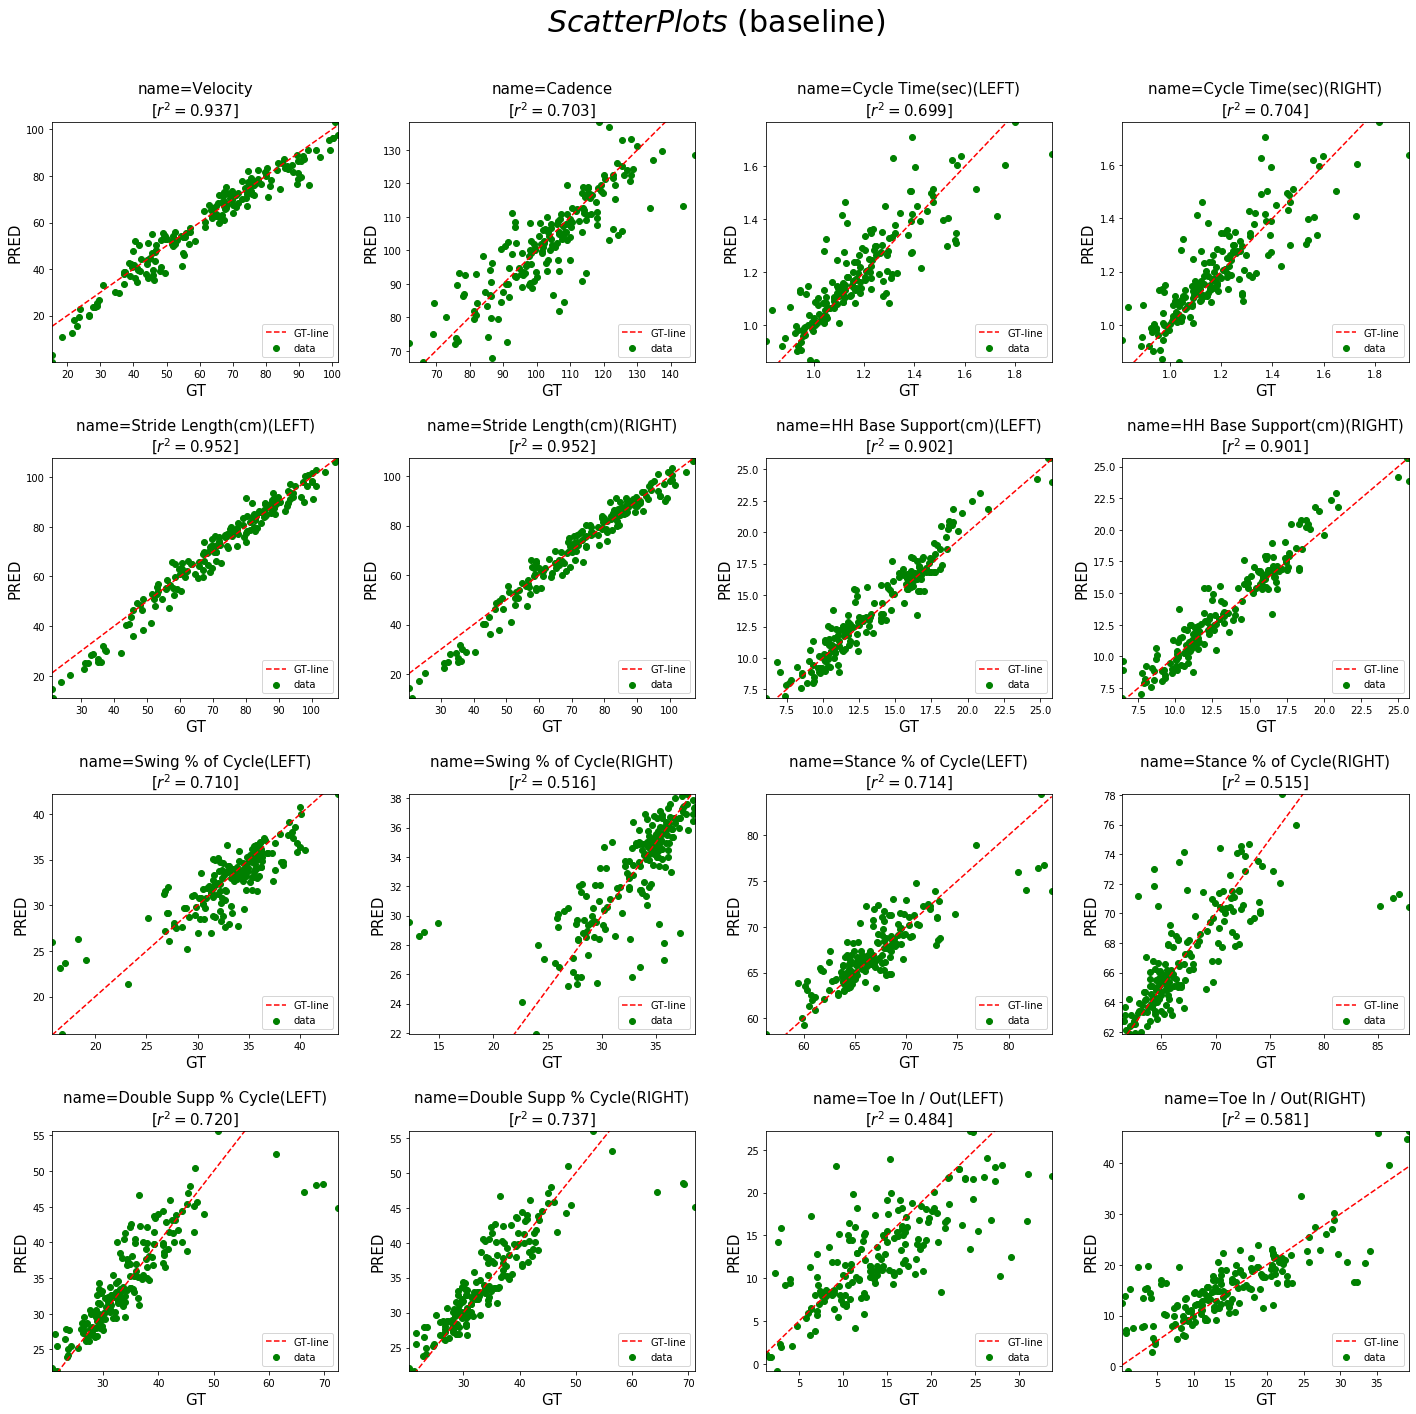

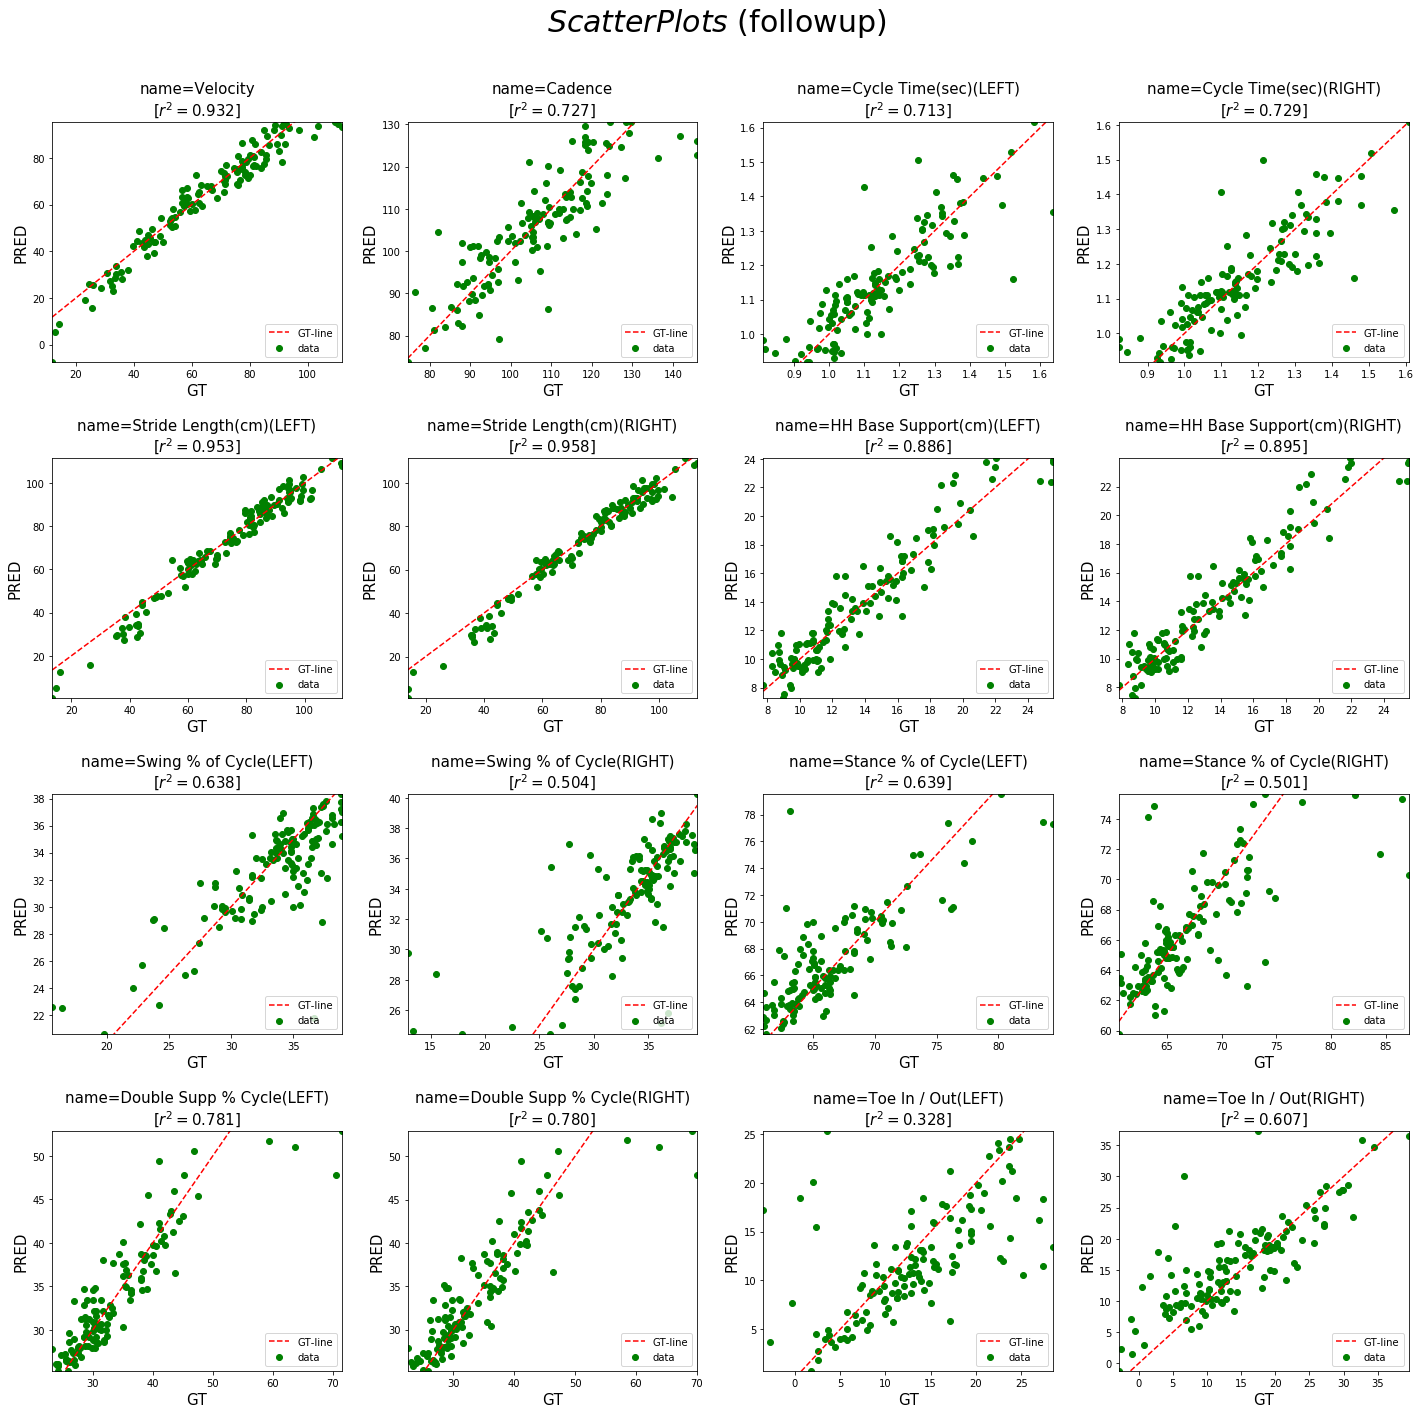

In [14]:
# scatter plots
for condition in analysis_data:
    y_true, y_pred, scores = analysis_data.get(condition)
    scatterplots(target_columns[:-4], y_true.values, y_pred.values, scores, condition)
    plt.show()

# Bland-Altman Plots 

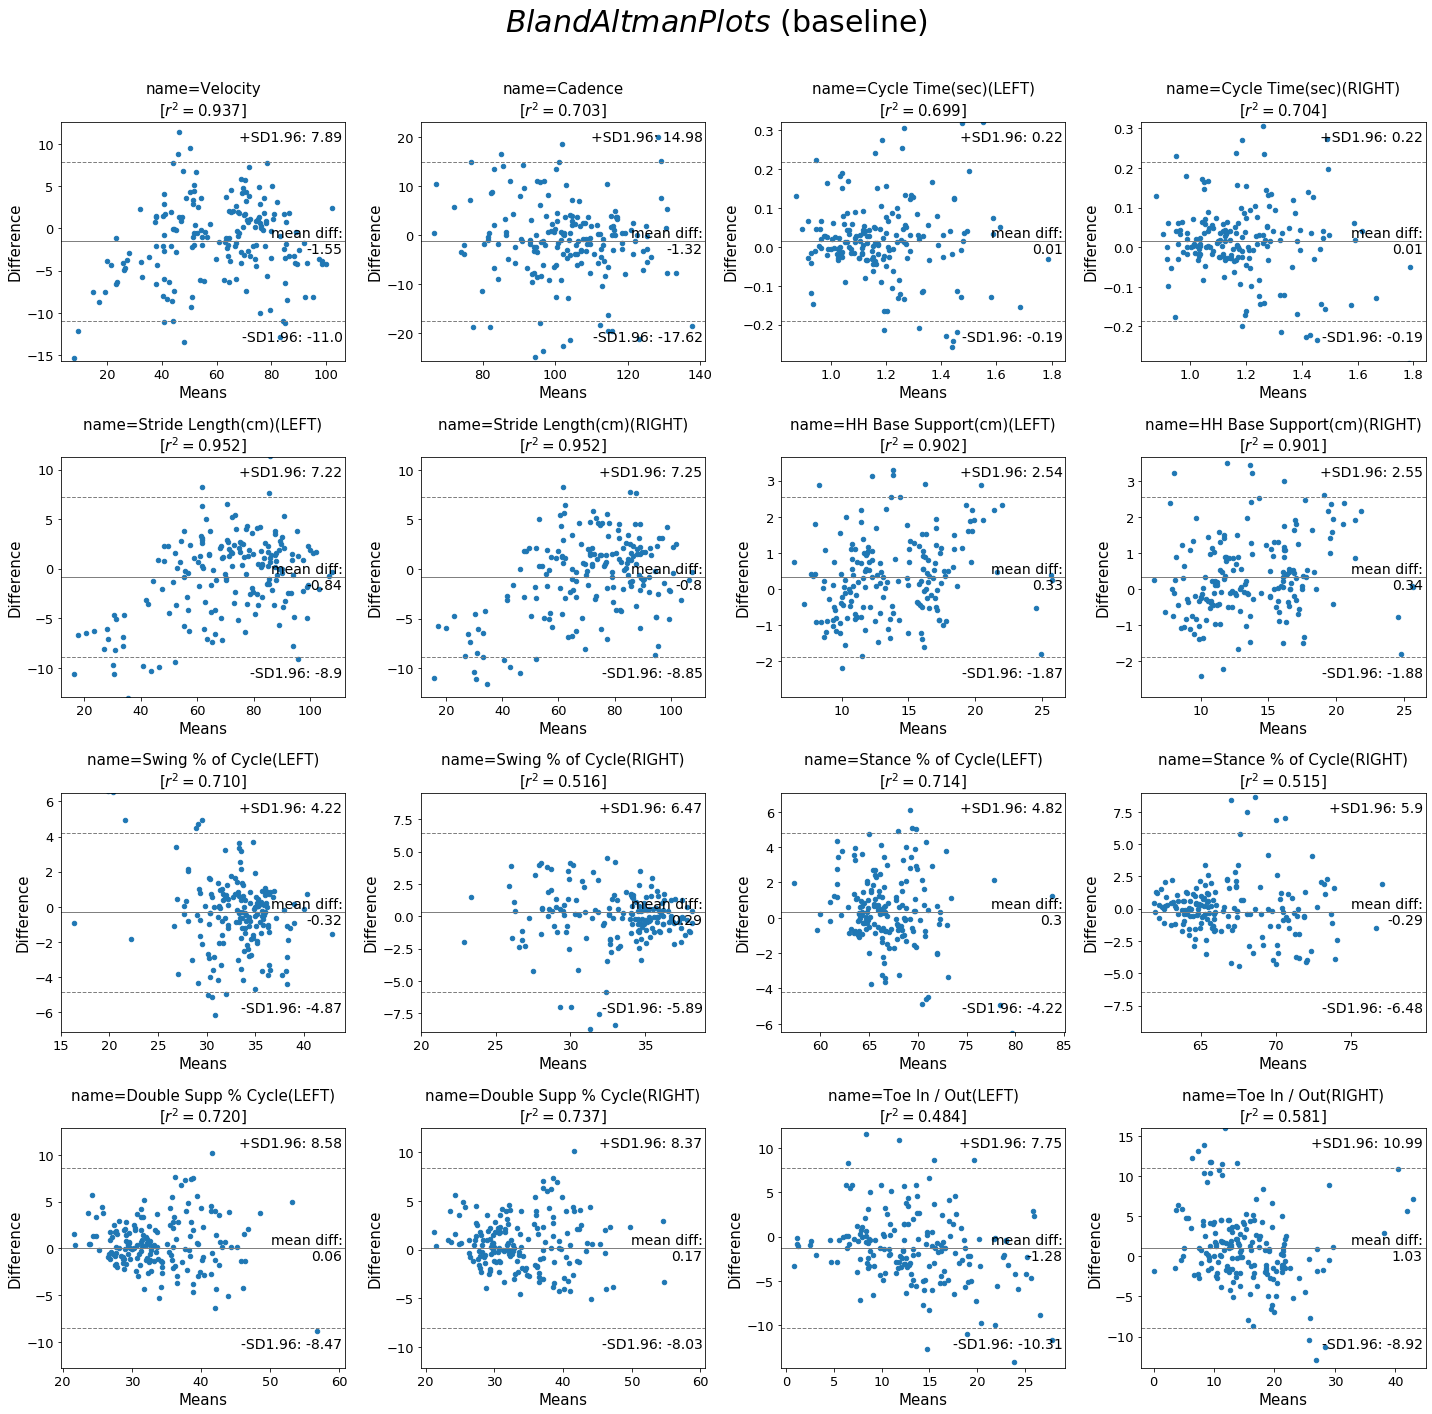

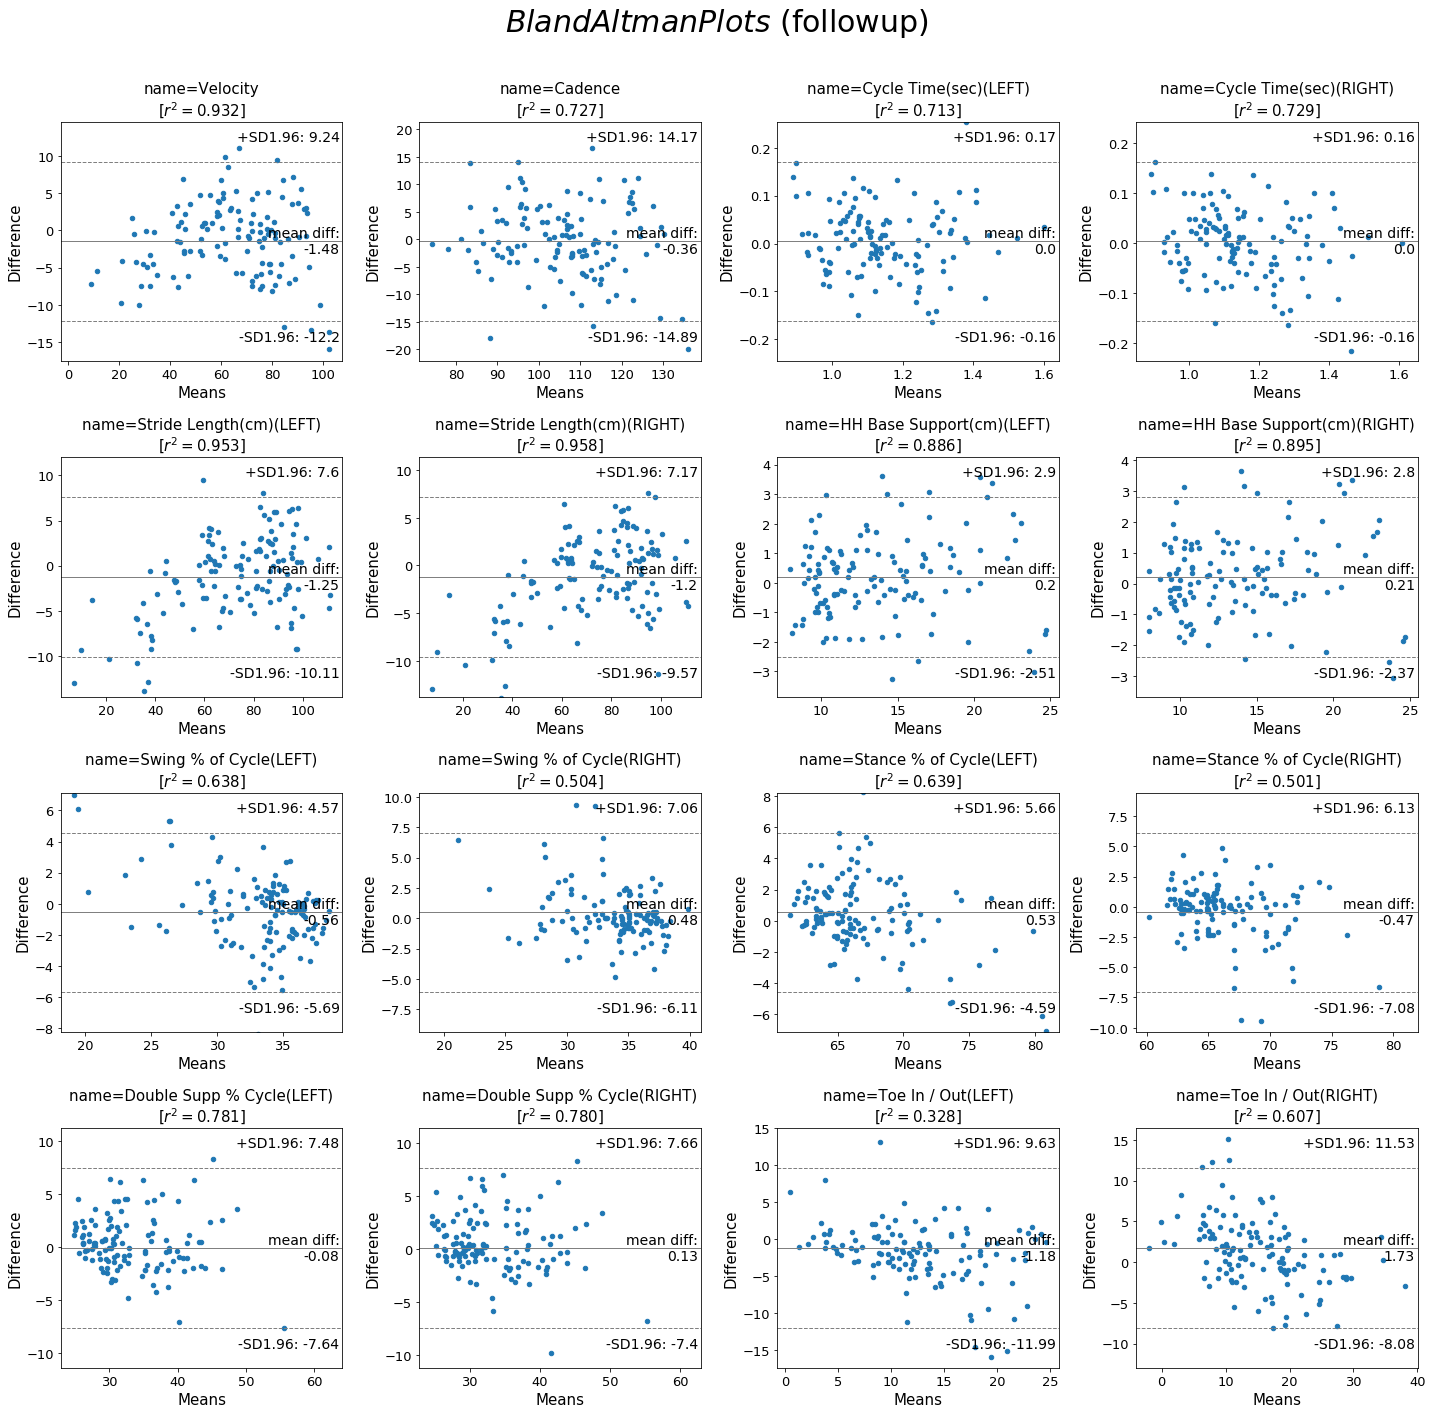

In [15]:
# BlandAltmanplots 
for condition in analysis_data:
    y_true, y_pred, scores = analysis_data.get(condition)
    BlandAltmanplots(target_columns[:-4], y_true.values, y_pred.values, condition)
    plt.show()

# Pearson's coefficents(GT<->PRED) of each group

In [16]:
from scipy.stats import pearsonr
def compute_pearson_coeff(x,y):
    if any(x.columns != y.columns):
        raise Exception('columns of x and y are not matched!')
    
    columns = x.columns
    
    res = []
    for col in columns:
        r_val, p_val = pearsonr(x[col], y[col])
        res.append((col,r_val,p_val))
        
    return pd.DataFrame(res, columns=['PARAMS','r','p-val'])

for condition in analysis_data:
    y_true, y_pred, scores = analysis_data.get(condition)
    print(f'[Pearson\'s coeff (R) for \'{condition}\' group @ N={len(y_true)}]\n\n', compute_pearson_coeff(y_true, y_pred), '\n')

[Pearson's coeff (R) for 'baseline' group @ N=182]

                         PARAMS         r          p-val
0                     Velocity  0.972668  4.371762e-116
1                      Cadence  0.846722   3.268775e-51
2        Cycle Time(sec)(LEFT)  0.843586   1.741996e-50
3       Cycle Time(sec)(RIGHT)  0.845756   5.495619e-51
4      Stride Length(cm)(LEFT)  0.982775  6.173209e-134
5     Stride Length(cm)(RIGHT)  0.982900  3.222070e-134
6    HH Base Support(cm)(LEFT)  0.959322  8.379382e-101
7   HH Base Support(cm)(RIGHT)  0.958438  5.574741e-100
8       Swing % of Cycle(LEFT)  0.846186   4.362166e-51
9      Swing % of Cycle(RIGHT)  0.722407   1.179769e-30
10     Stance % of Cycle(LEFT)  0.848141   1.514099e-51
11    Stance % of Cycle(RIGHT)  0.721388   1.557385e-30
12   Double Supp % Cycle(LEFT)  0.850686   3.733205e-52
13  Double Supp % Cycle(RIGHT)  0.860545   1.272635e-54
14          Toe In / Out(LEFT)  0.727403   2.966147e-31
15         Toe In / Out(RIGHT)  0.776863   5.273995

In [67]:
baseline_data = res['baseline']
baseline_data = {'gt': baseline_data[baseline_data.Type=='gt'],
                 'pred': baseline_data[baseline_data.Type=='pred']}

followup_data = res['followup']
followup_data = {'gt': followup_data[followup_data.Type=='gt'],
                 'pred': followup_data[followup_data.Type=='pred']}

In [68]:
all_data_gt = pd.concat((baseline_data['gt'], followup_data['gt']))
grouped_data_gt = all_data_gt.groupby(["PAT ID", "GROUP"]).apply(lambda x: x.mean()).loc[:, target_columns[0]:target_columns[-5]]

delta_gt = (grouped_data_gt.xs('followup', level="GROUP")-grouped_data_gt.xs('baseline', level="GROUP"))/grouped_data_gt.xs('baseline', level="GROUP")
delta_gt = delta_gt.dropna() # remove all un-paired rows
delta_gt *= 100

grouped_data_gt.columns = [ x+'_gt' for x in grouped_data_gt.columns ]
delta_gt.columns = [ r'$\Delta$'+x+'_gt' for x in delta_gt.columns ]

all_data_pred = pd.concat((baseline_data['pred'], followup_data['pred']))
grouped_data_pred = all_data_pred.groupby(["PAT ID", "GROUP"]).apply(lambda x: x.mean()).loc[:, target_columns[0]:target_columns[-5]]

delta_pred =(grouped_data_pred.xs('followup', level="GROUP")-grouped_data_pred.xs('baseline', level="GROUP"))/grouped_data_pred.xs('baseline', level="GROUP")
delta_pred = delta_pred.dropna() # remove all un-paired rows
delta_pred *= 100

grouped_data_pred.columns = [ x+'_pred' for x in grouped_data_pred.columns ]
delta_pred.columns = [ r'$\Delta$'+x+'_pred' for x in delta_pred.columns ]

# integrated df
integrated_df = pd.concat((grouped_data_gt, grouped_data_pred), axis=1)
integrated_df.reset_index(level=["GROUP"], inplace=True)

# integrated delta_dfs
integrated_delta_df = pd.concat((delta_gt, delta_pred), axis=1)

print(f'# of fully paired patients (i.e. both baseline & followup exists!) : {len(integrated_delta_df)}')

# of fully paired patients (i.e. both baseline & followup exists!) : 32


In [69]:
grouped_data_pred.xs('followup', level="GROUP").head()

,Velocity_pred,Cadence_pred,Cycle Time(sec)(LEFT)_pred,Cycle Time(sec)(RIGHT)_pred,Stride Length(cm)(LEFT)_pred,Stride Length(cm)(RIGHT)_pred,HH Base Support(cm)(LEFT)_pred,HH Base Support(cm)(RIGHT)_pred,Swing % of Cycle(LEFT)_pred,Swing % of Cycle(RIGHT)_pred,Stance % of Cycle(LEFT)_pred,Stance % of Cycle(RIGHT)_pred,Double Supp % Cycle(LEFT)_pred,Double Supp % Cycle(RIGHT)_pred,Toe In / Out(LEFT)_pred,Toe In / Out(RIGHT)_pred
PAT ID,,,,,,,,,,,,,,,,
1156017,55.353471,113.120350,1.060298,1.063859,59.966534,59.924752,12.326198,12.345224,32.193893,31.473216,67.739143,68.547745,36.503826,36.540100,12.634966,10.630050
1372485,70.951752,92.550043,1.289021,1.289033,91.929359,91.920000,16.137107,16.156368,33.972705,34.501994,65.968782,65.492926,31.935370,32.118027,3.449309,4.413522
1419701,67.332693,104.142740,1.148851,1.148139,78.123564,78.131361,9.433039,9.406634,33.243331,33.509558,66.684580,66.502579,33.405794,33.608716,3.709932,12.148546
1762188,92.555996,102.084734,1.166386,1.166521,108.735985,108.719084,14.439929,14.447496,35.519284,37.336578,64.388399,62.642797,27.022602,27.049764,5.268954,9.828557
1789841,76.589340,109.514273,1.091581,1.094598,84.859529,84.957586,9.317391,9.286534,34.639923,34.939648,65.288078,65.142430,30.342587,30.561328,11.314069,16.666514


# Trends in improvement ($\Delta\$) % for each gait param

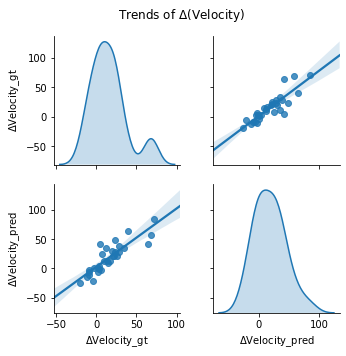

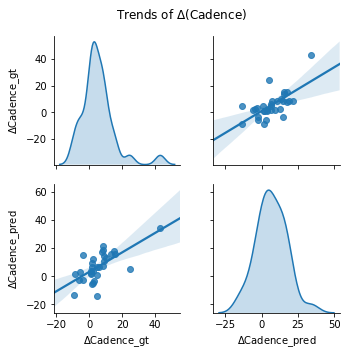

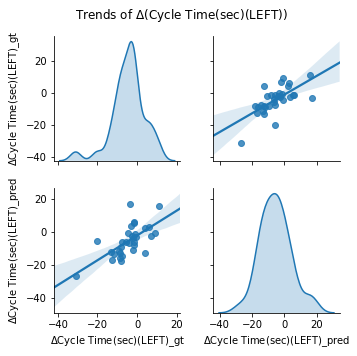

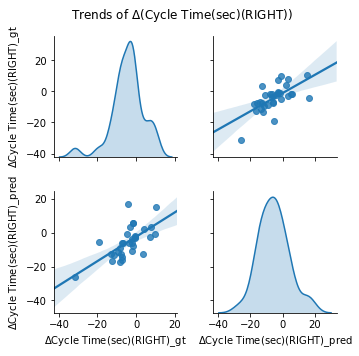

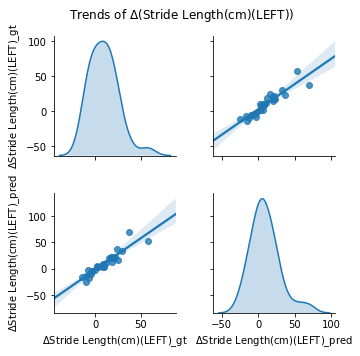

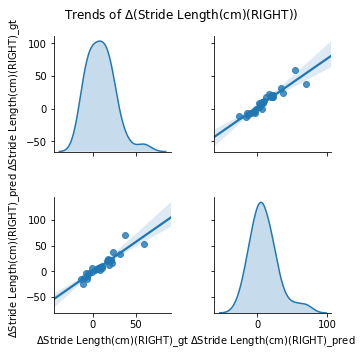

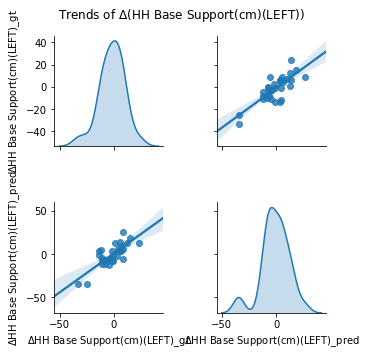

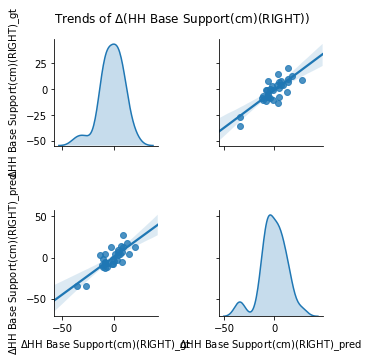

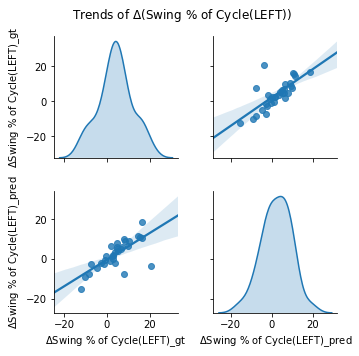

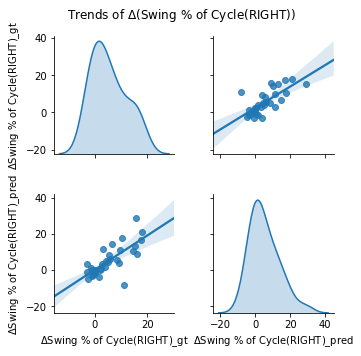

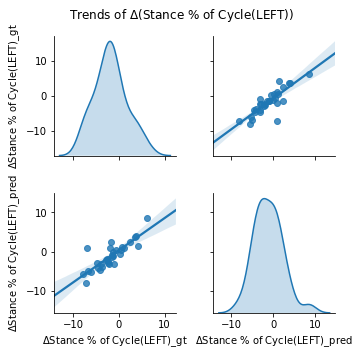

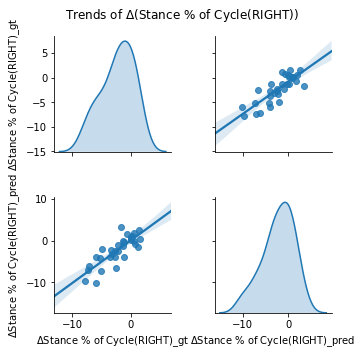

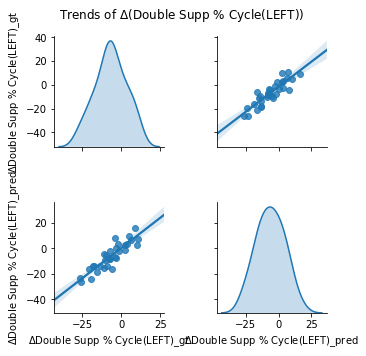

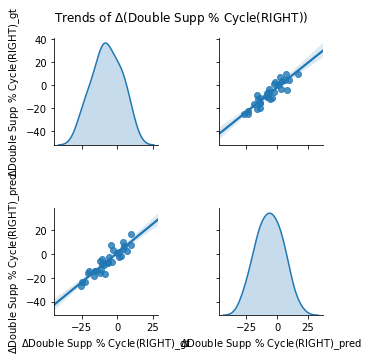

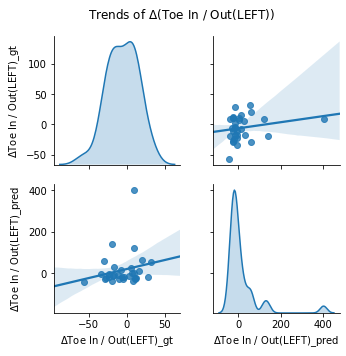

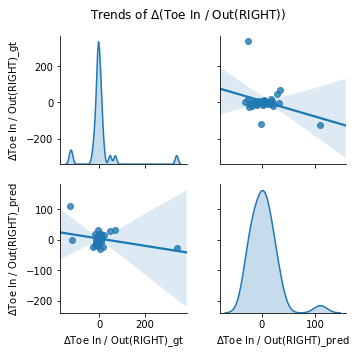

In [70]:
for name in target_columns[:-4]:
    g = sns.pairplot(integrated_delta_df, diag_kind='kde',
             vars=[r'$\Delta$'+f'{name}_gt',
                   r'$\Delta$'+f'{name}_pred'], kind='reg')
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(rf'Trends of $\Delta$({name})')

# Trends in each param for {baseline/followup} groups

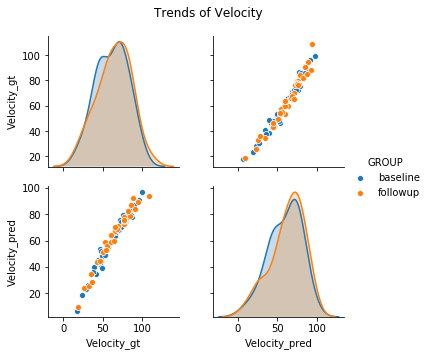

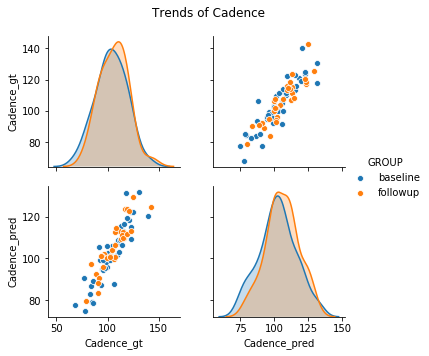

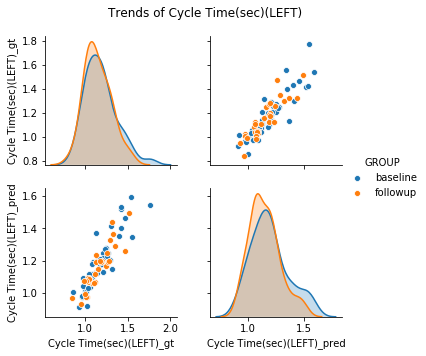

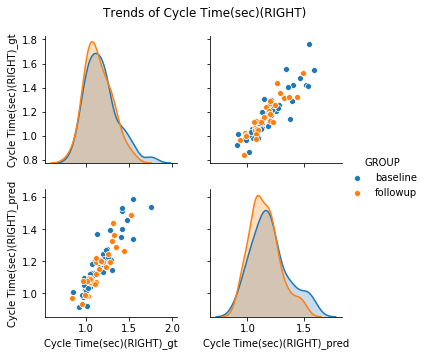

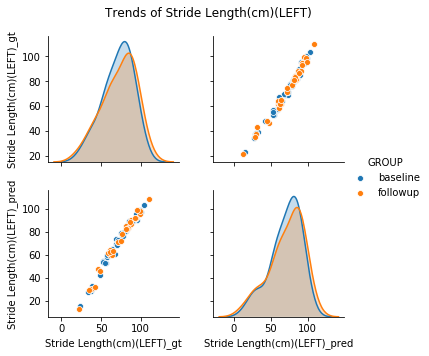

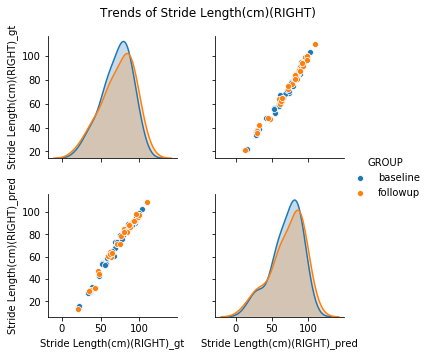

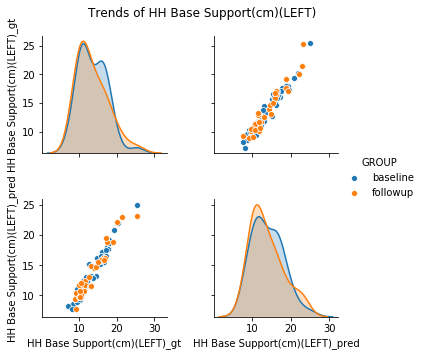

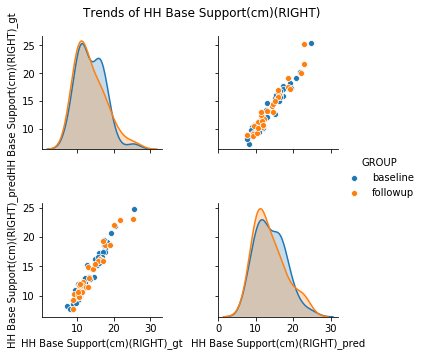

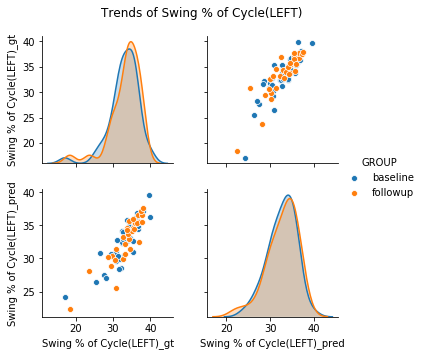

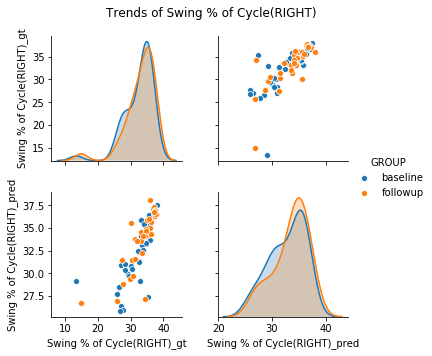

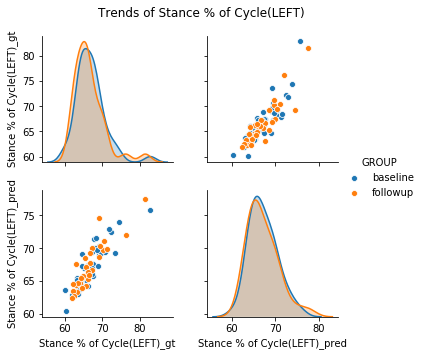

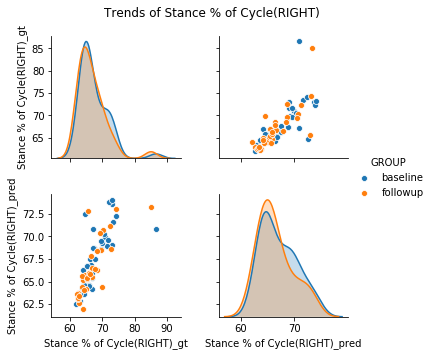

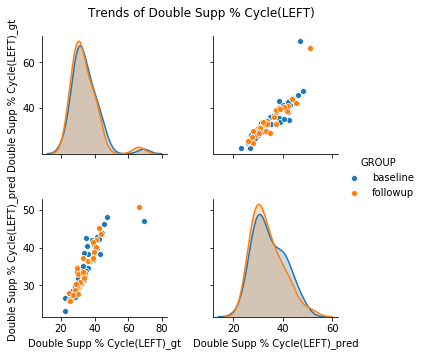

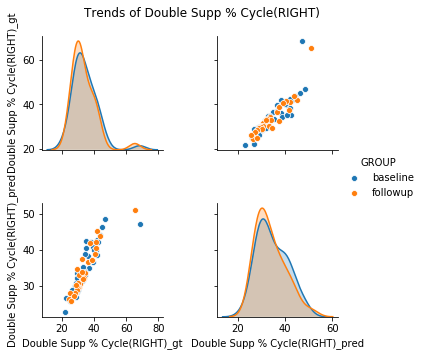

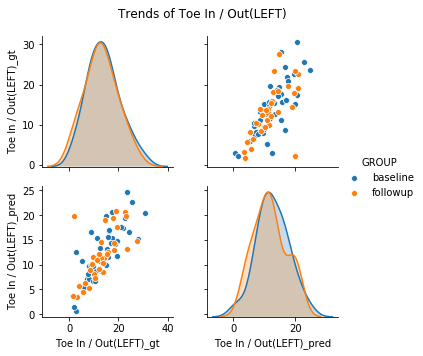

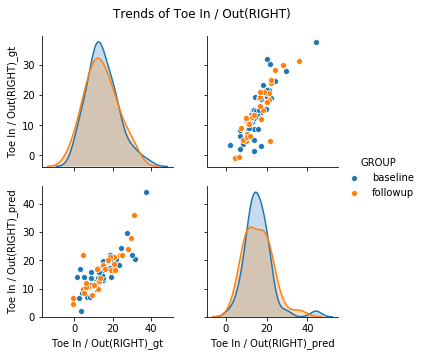

In [20]:
for name in target_columns[:-4]:
    g = sns.pairplot(integrated_df, vars=[f'{name}_gt', 
                                      f'{name}_pred'], hue="GROUP")
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Trends of {name}')

# Trends in improvement per each patient

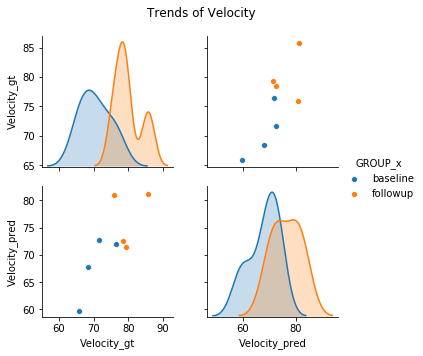

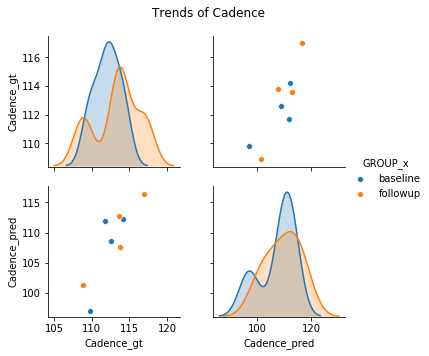

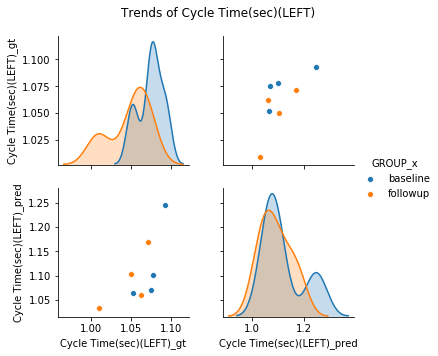

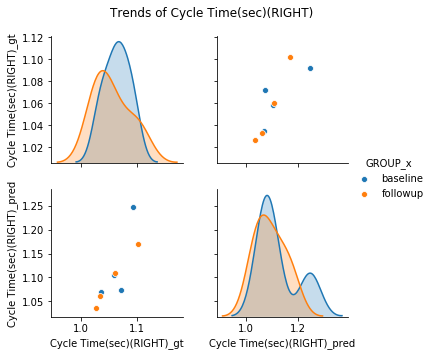

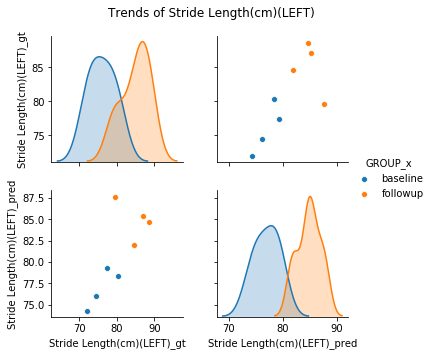

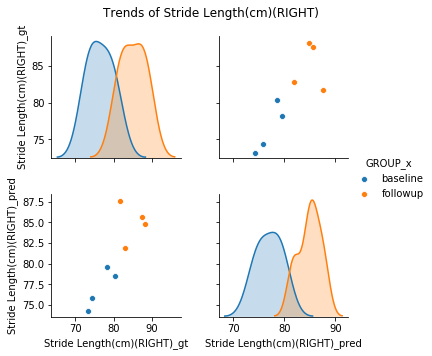

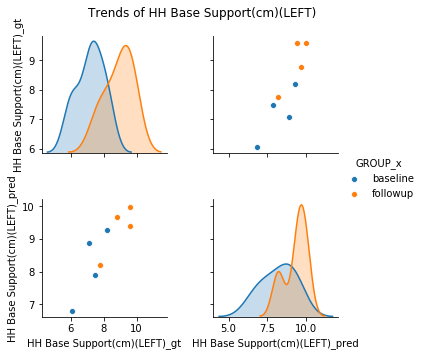

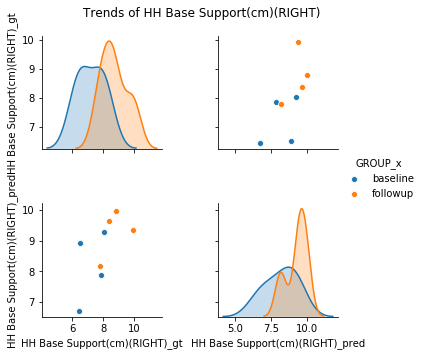

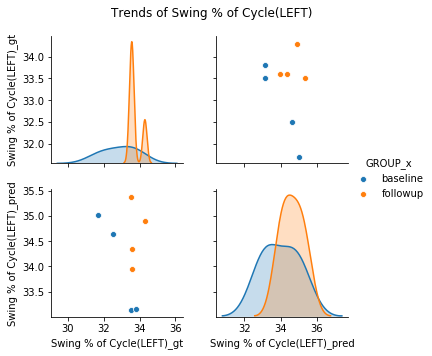

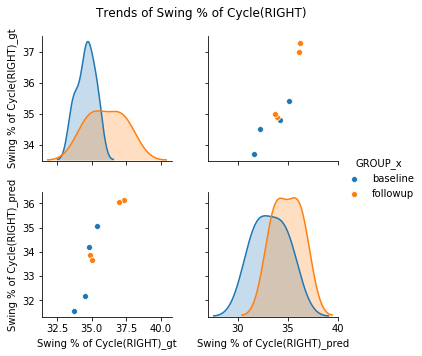

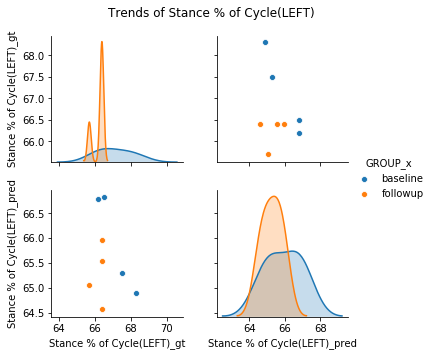

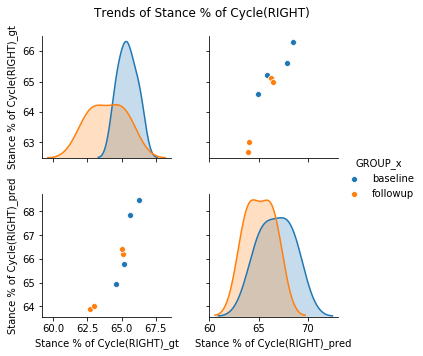

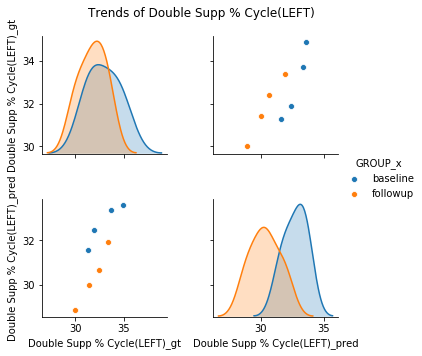

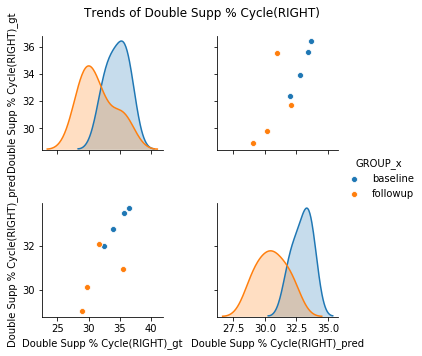

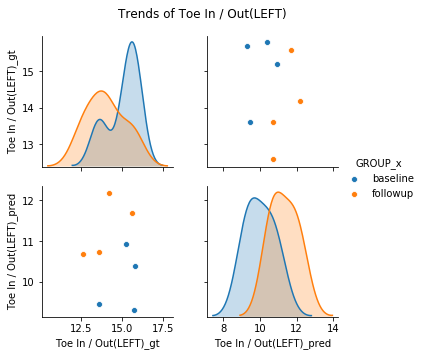

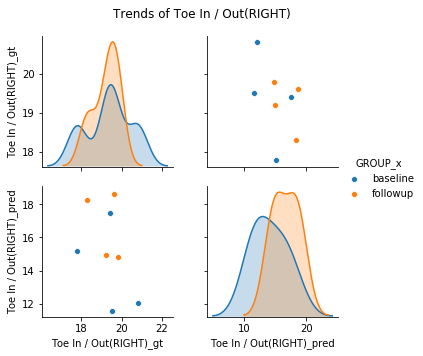

In [135]:
def plot_distributions_method_effect(pat_id):
    pat_data_gt = all_data_gt[all_data_gt["PAT ID"]==pat_id]
    pat_data_pred = all_data_pred[all_data_pred["PAT ID"]==pat_id]

    def modify_columns(d, suf):
        c = []
        for x in d.columns:
            suffix = ''
            if x in target_columns:
                suffix = suf
            c.append(x+suffix)

        d.columns = c

    modify_columns(pat_data_gt, suf='_gt')
    modify_columns(pat_data_pred, suf='_pred')

    pat_data = pd.merge(pat_data_gt, pat_data_pred, on='Serial Num')
    
    for name in target_columns[:-4]:
        g = sns.pairplot(pat_data, vars=[f'{name}_gt', 
                                          f'{name}_pred'], hue="GROUP_x")
        g.fig.subplots_adjust(top=0.9)
        g.fig.suptitle(f'Trends of {name}')

plot_distributions_method_effect(pat_id = 1789841)

# Correlation Matrix of improvements ($\Delta\$) for each param

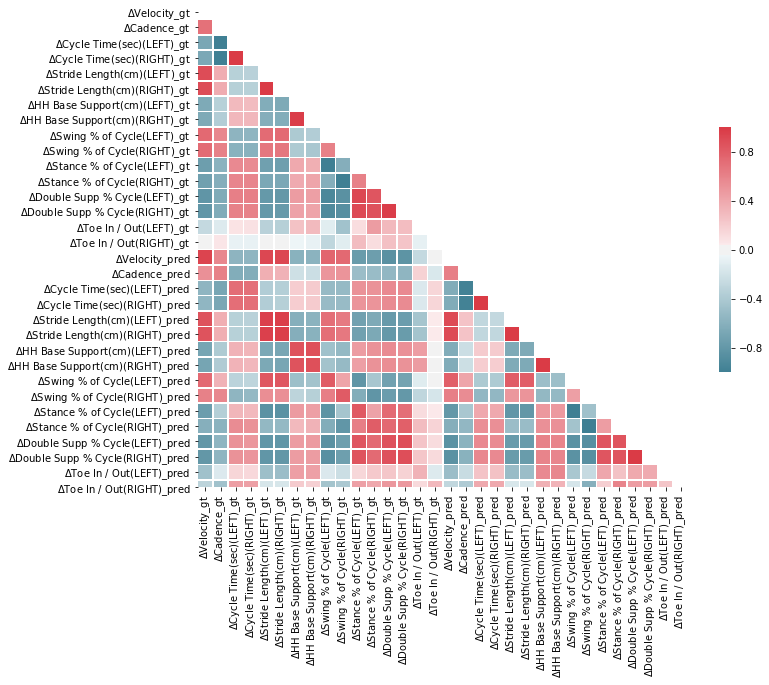

In [21]:
corr = integrated_delta_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Correlation Matrix (full)

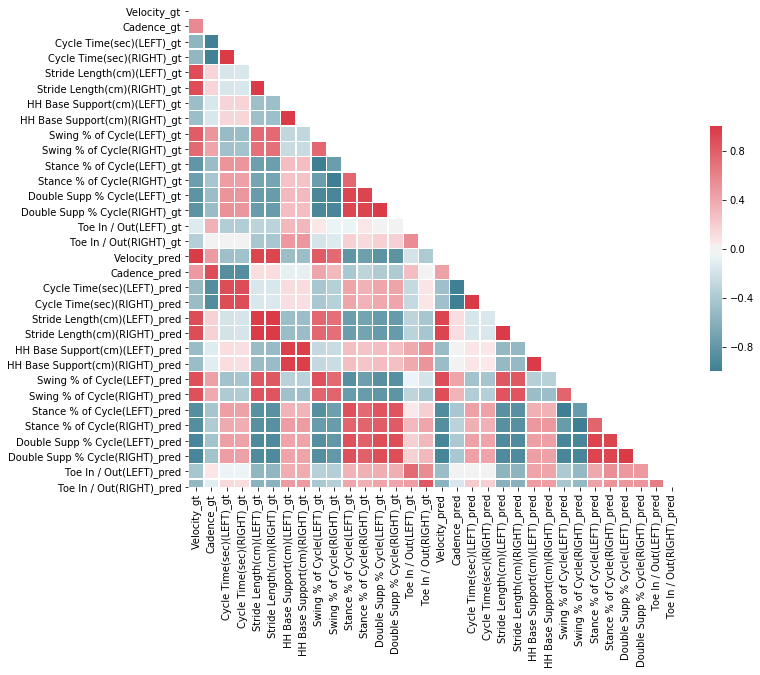

In [22]:
corr = integrated_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [23]:
# count summaries
print("#"*8, "COUNT SUMMARIES", "#"*8)
print(f"Patients used in \'baseline\' exp {np.unique(integrated_df[integrated_df.GROUP=='baseline'].index).shape[0]}")
print(f"Patients used in \'followup\' exp {np.unique(integrated_df[integrated_df.GROUP=='followup'].index).shape[0]}")
print(f"Patients used in \'delta\' exp {len(integrated_delta_df)}")

######## COUNT SUMMARIES ########
Patients used in 'baseline' exp 46
Patients used in 'followup' exp 32
Patients used in 'delta' exp 32


In [25]:
df.head()

,Serial Num,PAT ID,DATE,TIME,FILENAME,Step Count,Distance,Ambulation Time,Velocity,Cadence,...,Swing Time Std Dev(RIGHT),Stance Time Std Dev(RIGHT),Stride Velocity Std Dev(RIGHT),Single Supp Time Std Dev(RIGHT),Double Supp Time Std Dev(RIGHT),Heel Off On Std Dev(RIGHT),Supp Base On Std Dev(RIGHT),Foot Length(RIGHT),Foot Width(RIGHT),GROUP
0,5,1019153,2019-04-03,4:35:54,1019153_basic_test_3_trial_0.txt,20,464.53,14.23,32.6,84.3,...,0.045,0.041,2.741,0.033,0.067,0.031,0.997,20.9,5.9,baseline
1,6,1019153,2019-04-03,4:36:35,1019153_basic_test_3_trial_1.txt,17,460.82,10.57,43.6,96.5,...,0.047,0.064,3.605,0.032,0.037,0.050,0.758,20.8,7.5,baseline
2,7,1019153,2019-04-03,4:36:57,1019153_basic_test_3_trial_2.txt,18,445.89,10.41,42.8,103.7,...,0.043,0.039,3.424,0.045,0.017,0.040,1.100,20.9,6.9,baseline
3,8,1019153,2019-04-03,4:37:17,1019153_basic_test_3_trial_3.txt,17,449.25,9.55,47.0,106.8,...,0.014,0.065,5.872,0.048,0.034,0.045,0.914,20.5,7.6,baseline
4,1,1019153,2019-04-05,11:18:15,1019153_basic_test_2_trial_0.txt,16,467.25,8.97,52.1,107.0,...,0.039,0.051,4.461,0.032,0.046,0.044,0.675,20.7,6.0,followup


In [28]:
integrated_df[integrated_df.GROUP=='baseline'].head()

,GROUP,Velocity_gt,Cadence_gt,Cycle Time(sec)(LEFT)_gt,Cycle Time(sec)(RIGHT)_gt,Stride Length(cm)(LEFT)_gt,Stride Length(cm)(RIGHT)_gt,HH Base Support(cm)(LEFT)_gt,HH Base Support(cm)(RIGHT)_gt,Swing % of Cycle(LEFT)_gt,...,HH Base Support(cm)(LEFT)_pred,HH Base Support(cm)(RIGHT)_pred,Swing % of Cycle(LEFT)_pred,Swing % of Cycle(RIGHT)_pred,Stance % of Cycle(LEFT)_pred,Stance % of Cycle(RIGHT)_pred,Double Supp % Cycle(LEFT)_pred,Double Supp % Cycle(RIGHT)_pred,Toe In / Out(LEFT)_pred,Toe In / Out(RIGHT)_pred
PAT ID,,,,,,,,,,,,,,,,,,,,,
1156017,baseline,48.900,102.375,1.173250,1.16575,57.112500,58.041500,10.37850,10.64225,33.700,...,10.893003,10.897822,33.047389,28.516587,66.895260,71.546862,38.580740,38.741194,14.892671,12.810509
1194117,baseline,83.525,130.225,0.922500,0.92475,77.428750,78.128250,17.91525,18.17275,35.725,...,19.199109,19.140271,35.385585,36.365130,64.705189,63.613261,28.294436,28.143491,8.974277,11.637358
1227246,baseline,83.975,106.450,1.124500,1.12850,94.584000,95.251500,12.22325,11.82475,35.600,...,12.971706,12.878003,35.408343,36.072389,64.527050,63.950910,28.840196,28.796821,19.413257,24.331127
1372485,baseline,67.200,94.800,1.270333,1.25700,85.738667,85.264667,16.59000,15.92100,30.900,...,15.487469,15.479704,31.112982,34.543218,68.896787,65.444489,34.744244,34.913245,0.687842,2.102384
1419701,baseline,72.700,107.825,1.109750,1.10775,81.438250,82.265750,8.50075,8.67125,34.350,...,8.584131,8.628954,34.842127,34.066934,65.101349,65.939749,31.345539,31.567778,1.558239,11.631991


In [29]:
integrated_df[integrated_df.GROUP=='followup'].head()

,GROUP,Velocity_gt,Cadence_gt,Cycle Time(sec)(LEFT)_gt,Cycle Time(sec)(RIGHT)_gt,Stride Length(cm)(LEFT)_gt,Stride Length(cm)(RIGHT)_gt,HH Base Support(cm)(LEFT)_gt,HH Base Support(cm)(RIGHT)_gt,Swing % of Cycle(LEFT)_gt,...,HH Base Support(cm)(LEFT)_pred,HH Base Support(cm)(RIGHT)_pred,Swing % of Cycle(LEFT)_pred,Swing % of Cycle(RIGHT)_pred,Stance % of Cycle(LEFT)_pred,Stance % of Cycle(RIGHT)_pred,Double Supp % Cycle(LEFT)_pred,Double Supp % Cycle(RIGHT)_pred,Toe In / Out(LEFT)_pred,Toe In / Out(RIGHT)_pred
PAT ID,,,,,,,,,,,,,,,,,,,,,
1156017,followup,57.075,111.300,1.07925,1.06650,61.68075,61.21500,11.64750,11.64850,33.250,...,12.326198,12.345224,32.193893,31.473216,67.739143,68.547745,36.503826,36.540100,12.634966,10.630050
1372485,followup,69.725,88.875,1.34650,1.35425,94.35650,94.13775,16.41600,16.14725,34.050,...,16.137107,16.156368,33.972705,34.501994,65.968782,65.492926,31.935370,32.118027,3.449309,4.413522
1419701,followup,65.850,103.850,1.15400,1.15150,76.64050,76.60475,9.11850,9.01325,32.725,...,9.433039,9.406634,33.243331,33.509558,66.684580,66.502579,33.405794,33.608716,3.709932,12.148546
1762188,followup,88.175,96.375,1.24600,1.24125,110.00175,109.90825,13.96700,14.13400,37.050,...,14.439929,14.447496,35.519284,37.336578,64.388399,62.642797,27.022602,27.049764,5.268954,9.828557
1789841,followup,79.875,113.325,1.04800,1.05550,84.95600,85.07150,8.92625,8.71500,33.750,...,9.317391,9.286534,34.639923,34.939648,65.288078,65.142430,30.342587,30.561328,11.314069,16.666514


In [32]:
res['followup'].head()

,Serial Num,PAT ID,DATE,TIME,FILENAME,Velocity,Cadence,Cycle Time(sec)(LEFT),Cycle Time(sec)(RIGHT),Stride Length(cm)(LEFT),...,Swing % of Cycle(LEFT),Swing % of Cycle(RIGHT),Stance % of Cycle(LEFT),Stance % of Cycle(RIGHT),Double Supp % Cycle(LEFT),Double Supp % Cycle(RIGHT),Toe In / Out(LEFT),Toe In / Out(RIGHT),Type,GROUP
0,9,1156017,2018-11-28,03:59:48,1156017_basic_test_1_trial_0.txt,43.4,105.8,1.131,1.136,50.668,...,30.1,27.7,69.8,72.3,43.3,42.3,13.7,12.8,gt,followup
1,10,1156017,2018-11-28,04:00:19,1156017_basic_test_1_trial_1.txt,52.6,108.4,1.107,1.099,58.435,...,34.3,29.1,65.7,70.9,35,36.1,19.4,10.3,gt,followup
2,11,1156017,2018-11-28,04:00:38,1156017_basic_test_1_trial_2.txt,61.3,113.5,1.057,1.038,64.935,...,33.4,31.6,66.6,68.4,35.3,36,15,12.1,gt,followup
3,12,1156017,2018-11-28,04:00:56,1156017_basic_test_1_trial_3.txt,71,117.5,1.022,0.993,72.685,...,35.2,33.3,64.8,66.7,30.6,31.6,15.2,9.3,gt,followup
4,33,1372485,2017-11-29,09:04:33,1372485_basic_test_1_trial_0.txt,65.2,89.3,1.343,1.356,87.7,...,33.7,30.5,66.3,69.5,36.2,36.1,1.8,0.8,gt,followup


In [52]:
group

,GROUP,Velocity_gt,Cadence_gt,Cycle Time(sec)(LEFT)_gt,Cycle Time(sec)(RIGHT)_gt,Stride Length(cm)(LEFT)_gt,Stride Length(cm)(RIGHT)_gt,HH Base Support(cm)(LEFT)_gt,HH Base Support(cm)(RIGHT)_gt,Swing % of Cycle(LEFT)_gt,...,HH Base Support(cm)(LEFT)_pred,HH Base Support(cm)(RIGHT)_pred,Swing % of Cycle(LEFT)_pred,Swing % of Cycle(RIGHT)_pred,Stance % of Cycle(LEFT)_pred,Stance % of Cycle(RIGHT)_pred,Double Supp % Cycle(LEFT)_pred,Double Supp % Cycle(RIGHT)_pred,Toe In / Out(LEFT)_pred,Toe In / Out(RIGHT)_pred
PAT ID,,,,,,,,,,,,,,,,,,,,,
1156017,baseline,48.900,102.375,1.173250,1.16575,57.112500,58.041500,10.37850,10.64225,33.700,...,10.893003,10.897822,33.047389,28.516587,66.895260,71.546862,38.580740,38.741194,14.892671,12.810509
1156017,followup,57.075,111.300,1.079250,1.06650,61.680750,61.215000,11.64750,11.64850,33.250,...,12.326198,12.345224,32.193893,31.473216,67.739143,68.547745,36.503826,36.540100,12.634966,10.630050
1194117,baseline,83.525,130.225,0.922500,0.92475,77.428750,78.128250,17.91525,18.17275,35.725,...,19.199109,19.140271,35.385585,36.365130,64.705189,63.613261,28.294436,28.143491,8.974277,11.637358
1227246,baseline,83.975,106.450,1.124500,1.12850,94.584000,95.251500,12.22325,11.82475,35.600,...,12.971706,12.878003,35.408343,36.072389,64.527050,63.950910,28.840196,28.796821,19.413257,24.331127
1372485,baseline,67.200,94.800,1.270333,1.25700,85.738667,85.264667,16.59000,15.92100,30.900,...,15.487469,15.479704,31.112982,34.543218,68.896787,65.444489,34.744244,34.913245,0.687842,2.102384


In [60]:
df_map = {'all-gt': all_data_gt,
          'baseline-gt': res['baseline'][res['baseline'].Type=='gt'],
          'baseline-pred': res['baseline'][res['baseline'].Type=='pred'],
          'followup-gt': res['followup'][res['followup'].Type=='gt'],
          'followup-pred': res['followup'][res['followup'].Type=='pred'],
          'delta-gt': delta_gt,
          'delta-pred': delta_pred}

# output excel file
writer = pd.ExcelWriter('../data/NPH_analysis_results.xlsx', engine='xlsxwriter')
with writer:
    worksheets = []

    for title in df_map:
        worksheets.append(
            ( title, writer.book.add_worksheet(title) )
        )

    # copy existing sheets
    writer.sheets = dict((title, ws) for title,ws in worksheets)

    for title in writer.sheets:
        # Convert the dataframe to an XlsxWriter Excel object.
        df_map.get(title).to_excel(writer, sheet_name=title, index=(title.startswith('delta')))